In [1]:
%matplotlib inline
import numpy as n
import matplotlib.pyplot as p
import numpy.fft as fft
import scipy.signal as sig
import copy
import scipy
import healpy as hp
import cosmology
import aipy as a
import scipy.special as sp
import astropy.io.fits as fits
import getPower
import scipy.optimize as op
import scipy.signal as signal
import scipy.integrate as integrate
import scipy.interpolate as interp
pi=n.pi
c=299792458.
alphaGal=5.66
gammaGal=-.8
p0Gal=(10.**6.1)*(1e26*2.*1.38e-23/(c/150e6)**2.)**2.
r2=n.sqrt(2.)
littleh=.68
import capo.oqe as oqe

0.048252
[ 0.01051303  0.01766171  0.02492874 ...,  0.9296228   1.394404    1.945845  ]
(1316,)
(1316,)
(1316,)
[  4.5    4.5    4.5  ...,  34.38  34.38  34.38]
min klist
-1.97827209628


/Users/aaronew/Python/analysis/lib/python2.7/site-packages/capo/__init__.py:7: UserWarning: Warning: omnical not installed, not importing capo.omni
  warnings.warn("Warning: omnical not installed, not importing capo.omni")


In [4]:
rootDir='/Users/aaronew/Dropbox (MIT)/simulations-hera-eox/data/'
fileNames=[rootDir+'simulations/'+dName for dName in ['largeSpacings.npz',
                                       'CylinderNoGap_largeSpacings.npz',
                                       'CylinderShort_largeSpacings.npz',
                                       'CylinderShortNoGap_largeSpacings.npz',
                                       'Picket_largeSpacings.npz',
                                       'BackPlane_largeSpacings.npz',
                                       'Dipole_largeSpacings.npz']]
kernelNames=[rootDir+'simulatedBandpasses/'+dName for dName in ['CylinderBackplane_kernel.npz',
                                                               'CylinderBackplaneNoGap_kernel.npz',
                                                               'CylinderBackPlaneShort_kernel.npz',
                                                               'CylinderBackplaneShortNoGap_kernel.npz',
                                                               'PaneledFeed_kernel.npz']]
areaSq=n.zeros(len(fileNames))
areaSq[4]=0.0337676868671
areaSq[0]=0.0363576582083
areaSq[-2]=0.0298992126072
areaSq[3]=0.0296089580776
areaSq[2]=0.0292476292238
areaSq[1]=0.0360530698656
areaSq[-1]=0.0289696475686

labels=['Cylinder','No Gap','Short','Short No Gap','Picket','Backplane Only','Dipole Only']
colors=['k','grey','red','orange','magenta','blue','green']
dataFilesAll=[n.load(fName) for fName in fileNames]
kernelFilesAll=[n.load(fName) for fName in kernelNames]
kernelFiles=[]
dataFiles=[]

kernelFiles.append(kernelFilesAll[0])
kernelFiles.append(kernelFilesAll[3])
kernelFiles.append(kernelFilesAll[4])

dataFiles.append(dataFilesAll[0])
dataFiles.append(dataFilesAll[3])
dataFiles.append(dataFilesAll[4])
areaSq=areaSq[[0,3,4]]

(-70, 0)

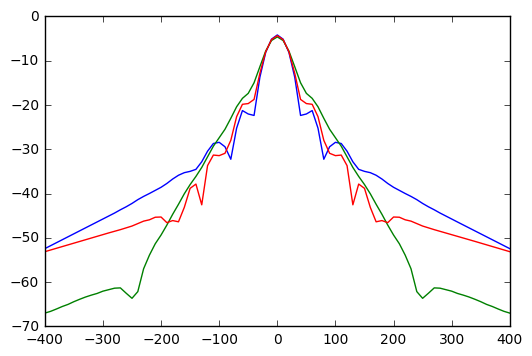

In [5]:
for kernelFile in kernelFiles:
    p.plot(kernelFile['tauInterp'],10.*n.log10(n.abs(kernelFile['bandInterp'])))

p.xlim(-400,400)
p.ylim(-70,0)


In [6]:
print kernelFiles[0].files
print kernelFiles[0]['bandInterp'].shape

['tauInterp', 'bandInterp']
(250,)


In [7]:
print dataFiles[0]['freq'][1]-dataFiles[0]['freq'][0]

400000.0


In [8]:
def gen_ps_signal(fAxis,uVal,beampp=1.,flux=True,ntimes=1):
    fc=fAxis[len(fAxis)/2]
    zc=cosmology.f2z(fc)
    delays=fft.fftshift(fft.fftfreq(len(fAxis),fAxis[1]-fAxis[0]))
    kParVals=cosmology.eta2kpara(delays,zc)
    kPerpVal=cosmology.u2kperp(uVal,zc)
    kvals=n.sqrt(kPerpVal**2.+kParVals**2.)
    stdPS=n.sqrt(getPower.ps21(n.abs(kvals),n.ones(len(kvals))*zc,flux=flux,beampp=beampp))
    #fit to power law and fill in where zero
    if(n.any(stdPS==0)):
        if( len(stdPS[stdPS==0])==1):
            posFit=n.logical_and(delays>0,delays<=500e-9)
            ppos,_=op.curve_fit(lambda x,a,b: a*n.abs(1+x)**b, delays[posFit],stdPS[posFit],p0=[n.std(stdPS),-1])
            stdPS[stdPS==0]=ppos[0]*(1+0)**ppos[1]
        else:
            isZero=stdPS==0
            minDelay=delays[isZero].max()
    #fit pos and neg
            posFit=n.logical_and(delays>minDelay,delays<=10*minDelay)
            negFit=n.logical_and(-delays>minDelay,-delays<=10*minDelay)
            ppos,_=op.curve_fit(lambda x,a,b: a*n.abs(1+x)**b, delays[posFit],stdPS[posFit],p0=[n.std(stdPS),-1])
            pneg,_=op.curve_fit(lambda x,a,b: a*n.abs(1+x)**b, delays[negFit],stdPS[negFit],p0=[n.std(stdPS),-1])
            posFill=n.logical_and(delays>=0,delays<=minDelay)
            stdPS[posFill]=ppos[0]*(1+delays[posFill])**ppos[1]
            negFill=n.logical_and(-delays>=0,-delays<=minDelay)
            stdPS[negFill]=pneg[0]*(1+delays[negFill])**pneg[1]
    psInstance=(n.random.randn(len(stdPS),ntimes)+1j*n.random.randn(len(stdPS),ntimes))/n.sqrt(2.)
    for mm in range(ntimes):
        psInstance[:,mm]*=stdPS
    return stdPS,psInstance

def empCov_avgLST(foregrounds,rFactor=1e-10):
    if(len(foregrounds.shape)==3):
        empCov=n.zeros((foregrounds.shape[0],foregrounds.shape[1],foregrounds.shape[1]),dtype=complex)
        empCovI=n.zeros_like(empCov)
        mu_foregrounds=n.mean(foregrounds,axis=-1)
        for mm in range(foregrounds.shape[0]):
            for nn in range(foregrounds.shape[-1]):
                empCov[mm,:,:]+=n.outer(foregrounds[mm,:,nn]-mu_foregrounds[mm,:],n.conj(foregrounds[mm,:,nn]-mu_foregrounds[mm,:]))
            empCov[mm,:,:]/=foregrounds.shape[-1]
            empCov[mm,:,:]+=n.identity(foregrounds.shape[1])*rFactor*n.abs(n.linalg.eig(empCov[mm,:,:])[0]).max()
            empCovI[mm,:,:]=n.linalg.inv(empCov[mm,:,:])
    else:
        empCov=n.zeros((foregrounds.shape[0],foregrounds.shape[0]),dtype=complex)
        empCovI=n.zeros_like(empCov)
        mu_foregrounds=n.mean(foregrounds,axis=1)
        for nn in range(foregrounds.shape[-1]):
            empCov+=n.outer(foregrounds[:,nn]-mu_foregrounds,n.conj(foregrounds[:,nn]-mu_foregrounds))

        empCov/=foregrounds.shape[-1]
        empCov+=n.identity(foregrounds.shape[0])*rFactor*n.abs(n.linalg.eig(empCov)[0]).max()
        empCovI=n.linalg.inv(empCov)
    return empCov,empCovI




#optimal quadratic estimator routine
#x: visibility vector
#wF: tapering function
#cInv: covariance matrix of visibility vector
#mode: normalization to use.
def oqeFunc(x,wF=None,cInv=None,mode='I'):
    modes=['F^-1','F^-1/2','L^-1','I']; assert(mode in modes)
    nf=len(x)
    if(cInv is None):
        cInv=n.identity(nf)
    if(wF is None):
        wF=n.ones(nf)
    qMatrices=n.zeros((nf,nf,nf),dtype=complex)
    qHat=n.zeros(nf,dtype=complex)
    pHat=n.zeros(nf,dtype=complex)
    wMat=n.zeros(nf,dtype=complex)
    mMat=n.zeros((nf,nf),dtype=complex)
    fMat=n.zeros((nf,nf),dtype=complex)
    #construct q matrices
    z=n.dot(cInv,x)
    #construct qhat
    for mm in range(nf):
        _m=n.zeros(nf)
        _m[mm]=1.
        m=fft.fft(fft.ifftshift(_m))
        qMat=n.einsum('i,j',m,m.conj())
        qMatrices[mm,:,:]=qMat
        qHat[mm]=n.dot(n.conj(z).T,n.dot(qMat,z))
    #construct fMat
    for mm in range(nf):
        for nn in range(nf):
            ftq=n.dot(cInv,n.dot(qMatrices[mm,:,:],n.dot(cInv,qMatrices[nn,:,:])))
            fMat[mm,nn]=n.trace(ftq)
    
    #print 'fMat condition=%e'%(n.linalg.cond(fMat))
    #if(n.linalg.cond(fMat)>1e10):
    #    fMat+=n.identity(fMat.shape[1])*1e-10*n.abs(n.linalg.eig(fMat)[0]).max()
    #    print 'regularized fMat condition=%e'%(n.linalg.cond(fMat))

    

    #construct mMat
    if(mode=='F^-1'):
        mMat=n.linalg.inv(fMat)
    elif(mode=='F^-1/2'):
        U,S,V=n.linalg.svd(fMat.conj())
        mMat=n.einsum('ij,j,jk',U.T,1./n.sqrt(S),V.T)
        fMatSqrt=scipy.linalg.sqrtm(fMat)
        #print 'Condition of Sqrt-F-matrix=%e'%(n.linalg.cond(fMatSqrt))
        mMat=n.linalg.inv(fMatSqrt)
    elif(mode=='L^-1'):
        order=n.zeros(nf)
        order[0]=nf/2
        order[1]=nf/2+1
        order[2]=nf/2-1
        order[3]=nf/2+2
        order[4]=nf/2-2
        order[5]=nf-1
        order[6]=0
        for mm in range(4,nf/2):
            order[2*mm-1]=nf/2+mm-1
            order[2*mm]=nf/2-mm+1
        order[-1]=1
        order=order.astype(int)
        #order = n.array([10,11,9,12,8,20,0,13,7,14,6,15,5,16,4,17,3,18,2,19,1]) # XXX needs generalizing
        iorder = n.argsort(order)
        fMat_o = n.take(n.take(fMat,order, axis=0), order, axis=1)
        lMat_o = n.linalg.cholesky(fMat_o)
        #print 'Condition of L-matrix=%e'%(n.linalg.cond(lMat_o))
        U,S,V = n.linalg.svd(lMat_o.conj())
        mMat_o = n.dot(n.transpose(V), n.dot(n.diag(1./S), n.transpose(U)))      
        mMat = n.take(n.take(mMat_o,iorder, axis=0), iorder, axis=1)
    elif(mode=='I'):
        mMat=n.identity(nf,dtype=complex)
        
    wMat=n.dot(mMat,fMat)
    norm  = wMat.sum(axis=-1); norm.shape += (1,)
    mMat/=norm; wMat=n.dot(mMat,fMat)
    pHat=n.dot(mMat,qHat)
    return qHat,pHat,wMat,fMat,qMatrices


def powerSpectrum(dataVector,zCenter,band,beamPP,df,mode='FFT',covMatInv=None,window=None):
    nFreq=len(dataVector)
    if(mode=='FFT'):
        if(window is None):
            window=signal.blackmanharris(nFreq);window/=n.sqrt(n.mean(window**2.))
        vTwiddleSq=(fft.fftshift(fft.fft(fft.fftshift(window*dataVector)))*df)**2.
    else:
        _,vTwiddleSq,_,_,_=oqeFunc(dataVector,wF=window,cInv=covMatInv,mode=mode)
        vTwiddleSq*=(nFreq*df)**2.
    f0=cosmology.z2f(zCenter)
    vTwiddleSq=n.abs(vTwiddleSq)
    return littleh**3.*(cosmology.X(f0)**2.*cosmology.Y(f0)*n.abs(cosmology.i2t(f0,n.sqrt(vTwiddleSq))**2.))*1e6/(beamPP*band)

In [9]:
lst=dataFiles[0]['lst']
fAxis=dataFiles[0]['freq']
df=fAxis[1]-fAxis[0]
nf=len(fAxis)
lst0=n.where(n.abs(lst-0).min()==n.abs(lst-0))[0][0]
lst60=n.where(n.abs(lst-60).min()==n.abs(lst-60))[0][0]

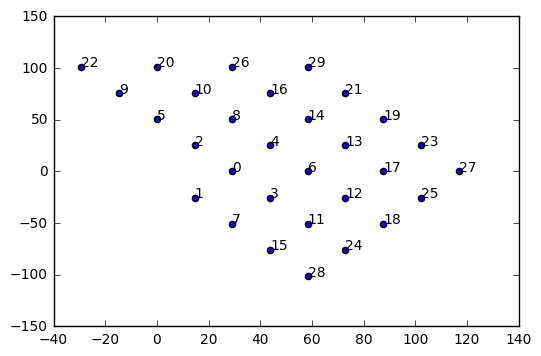

In [10]:
p.scatter(dataFiles[0]['bl'][:,0],dataFiles[0]['bl'][:,1])
for mm in range(dataFiles[0]['bl'].shape[0]):
    p.gca().text(dataFiles[0]['bl'][mm,0],dataFiles[0]['bl'][mm,1],'%d'%(mm))

85446283.5049 88775359.4856 92104435.4663


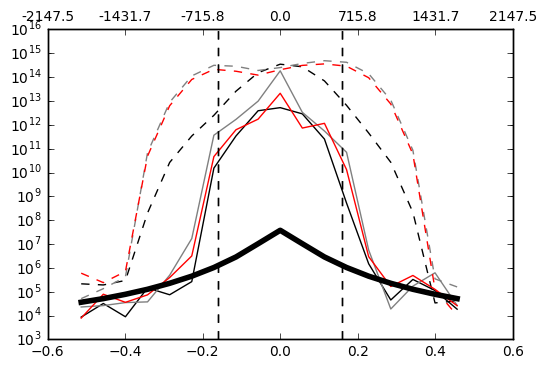

In [11]:
zC=15.
blIndex=27
lstBin=lst60
blLength=dataFiles[0]['bl_length'][blIndex]
delayHorizon=blLength/c
kParaHorizon=cosmology.eta2kpara(delayHorizon,zC)/littleh



fC=cosmology.z2f(zC)
bandWidth=-cosmology.dz2df(1.2,zC)
fLow=fC-bandWidth/2.
fHigh=fC+bandWidth/2.
print fLow,fC,fHigh
select=n.logical_and(fAxis>fLow,fAxis<=fHigh)

if(n.mod(len(select[select]),2)==1):
    maxInd=n.where(select)[0].max()
    select[maxInd+1]=True
nfs=len(select[select])
fAxisselect=fAxis[select]
tAxisselect=fft.fftshift(fft.fftfreq(nfs,fAxisselect[1]-fAxisselect[0]))
kParAxis=cosmology.eta2kpara(tAxisselect,zC)/littleh



for fileNum,dFile in enumerate(dataFiles):
    psSignalModel,psSignalInstances=gen_ps_signal(fAxisselect,dataFiles[0]['bl_length'][blIndex]/3e8*fC,areaSq[fileNum]*df*nfs,ntimes=dataFiles[0]['lst'].shape[0])
    psSignalViss=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances,axes=[0]),axis=0),axes=[0])/(df)
    fgCov,fgCovI=empCov_avgLST(dFile['skyvis_freq'][blIndex,select,:].squeeze()+psSignalViss,rFactor=0.)
    psFFT=powerSpectrum(dFile['skyvis_freq'][blIndex,select,lstBin]+psSignalViss[:,lstBin],zC,bandWidth,areaSq[fileNum],df,mode='FFT')
    psOQE=powerSpectrum(dFile['skyvis_freq'][blIndex,select,lstBin]+psSignalViss[:,lstBin],zC,bandWidth,areaSq[fileNum],df,mode='F^-1/2',covMatInv=fgCovI)
    p.plot(kParAxis,psFFT,ls='--',color=colors[fileNum])
    p.plot(kParAxis,psOQE,ls='-',color=colors[fileNum])

signalPS=gen_ps_signal(fAxisselect,dFile['bl_length'][blIndex]/c*fC,flux=False)
signalPS=signalPS[0]*signalPS[0]*littleh**3.
p.plot(kParAxis,signalPS,color='k',lw=4,ls='-')

p.axvline(-kParaHorizon,color='k',ls='--')
p.axvline(kParaHorizon,color='k',ls='--')
p.yscale('log')
p.ylim(1e3,1e16)

p.axvline(-kParaHorizon,color='k',ls='--')
p.axvline(kParaHorizon,color='k',ls='--')
p.yscale('log')
p.ylim(1e3,1e16)
ax1=p.gca()
ax2=p.gca().twiny()
ax2.set_xlim(ax1.get_xlim())
times=cosmology.kpara2eta(ax1.get_xticks(),zC)
ax2labels=[]
for tnum,xtick in enumerate(ax2.get_xticks()):
    ax2labels.append('%.1f'%(times[tnum]*1e9))
ax2.set_xticklabels(ax2labels)

79867105.4196 83553279.5159 87239453.6122


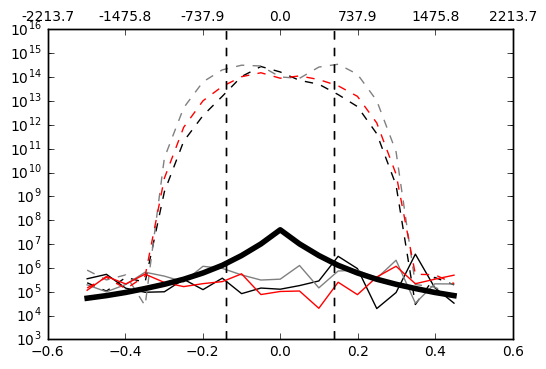

In [12]:
zC=16.
blIndex=24
lstBin=lst60
blLength=dataFiles[0]['bl_length'][blIndex]
delayHorizon=blLength/c
kParaHorizon=cosmology.eta2kpara(delayHorizon,zC)/littleh



fC=cosmology.z2f(zC)
bandWidth=-cosmology.dz2df(1.5,zC)
fLow=fC-bandWidth/2.
fHigh=fC+bandWidth/2.
print fLow,fC,fHigh
select=n.logical_and(fAxis>fLow,fAxis<=fHigh)

if(n.mod(len(select[select]),2)==1):
    maxInd=n.where(select)[0].max()
    select[maxInd+1]=True
nfs=len(select[select])
fAxisselect=fAxis[select]
tAxisselect=fft.fftshift(fft.fftfreq(nfs,fAxisselect[1]-fAxisselect[0]))
kParAxis=cosmology.eta2kpara(tAxisselect,zC)/littleh



for fileNum,dFile in enumerate(dataFiles):
    psSignalModel,psSignalInstances=gen_ps_signal(fAxisselect,dataFiles[0]['bl_length'][blIndex]/3e8*fC,areaSq[fileNum]*df*nfs,ntimes=dataFiles[0]['lst'].shape[0])
    psSignalViss=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances,axes=[0]),axis=0),axes=[0])/(df)
    fgCov,fgCovI=empCov_avgLST(dFile['skyvis_freq'][blIndex,select,:].squeeze()+1e0*psSignalViss,rFactor=0.)
    psFFT=powerSpectrum(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+psSignalViss[:,lstBin],zC,bandWidth,areaSq[fileNum],df,mode='FFT')
    psOQE=powerSpectrum(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+psSignalViss[:,lstBin],zC,bandWidth,areaSq[fileNum],df,mode='L^-1',covMatInv=fgCovI)
    p.plot(kParAxis,psFFT,ls='--',color=colors[fileNum])
    p.plot(kParAxis,psOQE,ls='-',color=colors[fileNum])

signalPS=gen_ps_signal(fAxisselect,dFile['bl_length'][blIndex]/c*fC,flux=False)
signalPS=signalPS[0]*signalPS[0]*littleh**3.
p.plot(kParAxis,signalPS,color='k',lw=4,ls='-')

p.axvline(-kParaHorizon,color='k',ls='--')
p.axvline(kParaHorizon,color='k',ls='--')
p.yscale('log')
p.ylim(1e3,1e16)

p.axvline(-kParaHorizon,color='k',ls='--')
p.axvline(kParaHorizon,color='k',ls='--')
p.yscale('log')
p.ylim(1e3,1e16)
ax1=p.gca()
ax2=p.gca().twiny()
ax2.set_xlim(ax1.get_xlim())
times=cosmology.kpara2eta(ax1.get_xticks(),zC)
ax2labels=[]
for tnum,xtick in enumerate(ax2.get_xticks()):
    ax2labels.append('%.1f'%(times[tnum]*1e9))
ax2.set_xticklabels(ax2labels)

79867105.4196 83553279.5159 87239453.6122


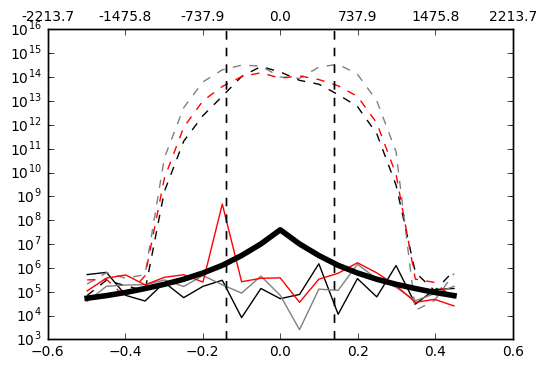

In [13]:
zC=16.
blIndex=24
lstBin=lst60
blLength=dataFiles[0]['bl_length'][blIndex]
delayHorizon=blLength/c
kParaHorizon=cosmology.eta2kpara(delayHorizon,zC)/littleh



fC=cosmology.z2f(zC)
bandWidth=-cosmology.dz2df(1.5,zC)
fLow=fC-bandWidth/2.
fHigh=fC+bandWidth/2.
print fLow,fC,fHigh
select=n.logical_and(fAxis>fLow,fAxis<=fHigh)

if(n.mod(len(select[select]),2)==1):
    maxInd=n.where(select)[0].max()
    select[maxInd+1]=True
nfs=len(select[select])
fAxisselect=fAxis[select]
tAxisselect=fft.fftshift(fft.fftfreq(nfs,fAxisselect[1]-fAxisselect[0]))
kParAxis=cosmology.eta2kpara(tAxisselect,zC)/littleh



for fileNum,dFile in enumerate(dataFiles):
    antkernel=n.abs(fft.fftshift(fft.fft(fft.fftshift(kernelFiles[fileNum]['bandInterp']))))[select]
    antkernel/=n.sqrt(n.mean(antkernel**2.))
    psSignalModel,psSignalInstances=gen_ps_signal(fAxisselect,dataFiles[0]['bl_length'][blIndex]/3e8*fC,areaSq[fileNum]*df*nfs,ntimes=dataFiles[0]['lst'].shape[0])
    psSignalViss=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances,axes=[0]),axis=0),axes=[0])/(df)
    fgCov,fgCovI=empCov_avgLST(dFile['skyvis_freq'][blIndex,select,:].squeeze()+1e0*psSignalViss,rFactor=0.)
    psFFT=powerSpectrum(1*(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+psSignalViss[:,lstBin]),zC,bandWidth,areaSq[fileNum],df,mode='FFT')
    psOQE=powerSpectrum(1*(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+psSignalViss[:,lstBin]),zC,bandWidth,areaSq[fileNum],df,mode='L^-1',covMatInv=fgCovI)
    p.plot(kParAxis,psFFT,ls='--',color=colors[fileNum])
    p.plot(kParAxis,psOQE,ls='-',color=colors[fileNum])

signalPS=gen_ps_signal(fAxisselect,dFile['bl_length'][blIndex]/c*fC,flux=False)
signalPS=signalPS[0]*signalPS[0]*littleh**3.
p.plot(kParAxis,signalPS,color='k',lw=4,ls='-')

p.axvline(-kParaHorizon,color='k',ls='--')
p.axvline(kParaHorizon,color='k',ls='--')
p.yscale('log')
p.ylim(1e3,1e16)

p.axvline(-kParaHorizon,color='k',ls='--')
p.axvline(kParaHorizon,color='k',ls='--')
p.yscale('log')
p.ylim(1e3,1e16)
ax1=p.gca()
ax2=p.gca().twiny()
ax2.set_xlim(ax1.get_xlim())
times=cosmology.kpara2eta(ax1.get_xticks(),zC)
ax2labels=[]
for tnum,xtick in enumerate(ax2.get_xticks()):
    ax2labels.append('%.1f'%(times[tnum]*1e9))
ax2.set_xticklabels(ax2labels)

79867105.4196 83553279.5159 87239453.6122


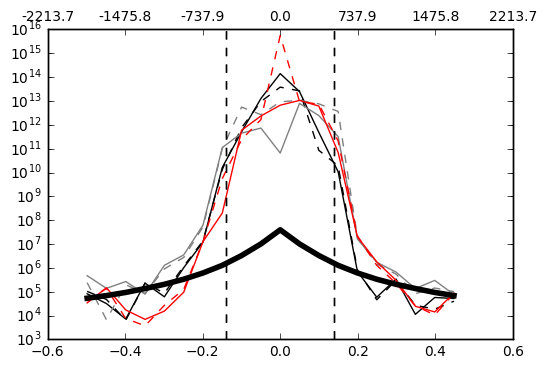

In [14]:
zC=16.
blIndex=24
lstBin=lst60
blLength=dataFiles[0]['bl_length'][blIndex]
delayHorizon=blLength/c
kParaHorizon=cosmology.eta2kpara(delayHorizon,zC)/littleh



fC=cosmology.z2f(zC)
bandWidth=-cosmology.dz2df(1.5,zC)
fLow=fC-bandWidth/2.
fHigh=fC+bandWidth/2.
print fLow,fC,fHigh
select=n.logical_and(fAxis>fLow,fAxis<=fHigh)

if(n.mod(len(select[select]),2)==1):
    maxInd=n.where(select)[0].max()
    select[maxInd+1]=True
nfs=len(select[select])
fAxisselect=fAxis[select]
tAxisselect=fft.fftshift(fft.fftfreq(nfs,fAxisselect[1]-fAxisselect[0]))
kParAxis=cosmology.eta2kpara(tAxisselect,zC)/littleh



for fileNum,dFile in enumerate(dataFiles):
    antkernel=n.abs(fft.fftshift(fft.fft(fft.fftshift(kernelFiles[fileNum]['bandInterp']))))[select]
    antkernel/=n.sqrt(n.mean(antkernel**2.))
    psSignalModel,psSignalInstances=gen_ps_signal(fAxisselect,dataFiles[0]['bl_length'][blIndex]/3e8*fC,areaSq[fileNum]*df*nfs,ntimes=dataFiles[0]['lst'].shape[0])
    psSignalViss=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances,axes=[0]),axis=0),axes=[0])/(df)
    fgCov,fgCovI=empCov_avgLST(dFile['skyvis_freq'][blIndex,select,:].squeeze()+1e0*psSignalViss,rFactor=0.)
    _,kernelGrid=n.meshgrid(n.ones(len(dFile['lst'])),antkernel)
    fgCovk,fgCovIk=empCov_avgLST(kernelGrid*(dFile['skyvis_freq'][blIndex,select,:].squeeze()+1e0*psSignalViss),rFactor=0.)
    psOQEkernel=powerSpectrum(antkernel*(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+psSignalViss[:,lstBin]),zC,bandWidth,areaSq[fileNum],df,mode='F^-1/2',covMatInv=fgCovIk)
    psOQE=powerSpectrum(1*(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+psSignalViss[:,lstBin]),zC,bandWidth,areaSq[fileNum],df,mode='F^-1/2',covMatInv=fgCovI)
    p.plot(kParAxis,psOQEkernel,ls='--',color=colors[fileNum])
    p.plot(kParAxis,psOQE,ls='-',color=colors[fileNum])

signalPS=gen_ps_signal(fAxisselect,dFile['bl_length'][blIndex]/c*fC,flux=False)
signalPS=signalPS[0]*signalPS[0]*littleh**3.
p.plot(kParAxis,signalPS,color='k',lw=4,ls='-')

p.axvline(-kParaHorizon,color='k',ls='--')
p.axvline(kParaHorizon,color='k',ls='--')
p.yscale('log')
p.ylim(1e3,1e16)

p.axvline(-kParaHorizon,color='k',ls='--')
p.axvline(kParaHorizon,color='k',ls='--')
p.yscale('log')
p.ylim(1e3,1e16)
ax1=p.gca()
ax2=p.gca().twiny()
ax2.set_xlim(ax1.get_xlim())
times=cosmology.kpara2eta(ax1.get_xticks(),zC)
ax2labels=[]
for tnum,xtick in enumerate(ax2.get_xticks()):
    ax2labels.append('%.1f'%(times[tnum]*1e9))
ax2.set_xticklabels(ax2labels)

79867105.4196 83553279.5159 87239453.6122
fMat condition=4.797343e+18
Condition of Sqrt-F-matrix=2.896142e+09
fMat condition=3.923959e+18
Condition of Sqrt-F-matrix=4.513191e+09
fMat condition=9.128419e+18
Condition of Sqrt-F-matrix=5.070083e+09
fMat condition=6.841271e+17
Condition of Sqrt-F-matrix=3.616700e+09
fMat condition=4.994546e+18
Condition of Sqrt-F-matrix=1.277655e+09
fMat condition=1.786301e+19
Condition of Sqrt-F-matrix=1.972647e+09


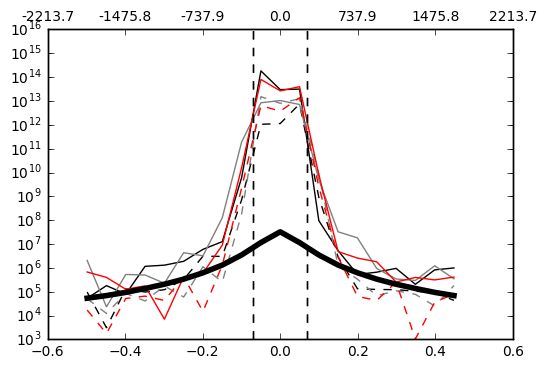

In [69]:
zC=16.
blIndex=24
lstBin=lst60
blLength=dataFiles[0]['bl_length'][blIndex]
delayHorizon=blLength/c
kParaHorizon=cosmology.eta2kpara(delayHorizon,zC)/littleh



fC=cosmology.z2f(zC)
bandWidth=-cosmology.dz2df(1.5,zC)
fLow=fC-bandWidth/2.
fHigh=fC+bandWidth/2.
print fLow,fC,fHigh
select=n.logical_and(fAxis>fLow,fAxis<=fHigh)

if(n.mod(len(select[select]),2)==1):
    maxInd=n.where(select)[0].max()
    select[maxInd+1]=True
nfs=len(select[select])
fAxisselect=fAxis[select]
tAxisselect=fft.fftshift(fft.fftfreq(nfs,fAxisselect[1]-fAxisselect[0]))
kParAxis=cosmology.eta2kpara(tAxisselect,zC)/littleh



for fileNum,dFile in enumerate(dataFiles):
    antkernel=n.abs(fft.fftshift(fft.fft(fft.fftshift(kernelFiles[fileNum]['bandInterp']))))[select]
    antkernel/=n.sqrt(n.mean(antkernel**2.))
    psSignalModel,psSignalInstances=gen_ps_signal(fAxisselect,dataFiles[0]['bl_length'][blIndex]/3e8*fC,areaSq[fileNum]*df*nfs,ntimes=dataFiles[0]['lst'].shape[0])
    psSignalViss=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances,axes=[0]),axis=0),axes=[0])/(df)
    fgCov,fgCovI=empCov_avgLST(dFile['skyvis_freq'][blIndex,select,:].squeeze()+1e0*psSignalViss,rFactor=0.)
    _,kernelGrid=n.meshgrid(n.ones(len(dFile['lst'])),antkernel)
    fgCovk,fgCovIk=empCov_avgLST(kernelGrid*(dFile['skyvis_freq'][blIndex,select,:].squeeze()+1e0*psSignalViss),rFactor=0.)
    psOQEkernel=powerSpectrum(antkernel*(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+psSignalViss[:,lstBin]),zC,bandWidth,areaSq[fileNum],df,mode='F^-1/2',covMatInv=fgCovIk)
    psOQE=powerSpectrum(antkernel*(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+psSignalViss[:,lstBin]),zC,bandWidth,areaSq[fileNum],df,mode='F^-1/2',covMatInv=fgCovI)
    p.plot(kParAxis,psOQEkernel,ls='--',color=colors[fileNum])
    p.plot(kParAxis,psOQE,ls='-',color=colors[fileNum])

signalPS=gen_ps_signal(fAxisselect,dFile['bl_length'][blIndex]/c*fC,flux=False)
signalPS=signalPS[0]*signalPS[0]*littleh**3.
p.plot(kParAxis,signalPS,color='k',lw=4,ls='-')

p.axvline(-kParaHorizon,color='k',ls='--')
p.axvline(kParaHorizon,color='k',ls='--')
p.yscale('log')
p.ylim(1e3,1e16)

p.axvline(-kParaHorizon,color='k',ls='--')
p.axvline(kParaHorizon,color='k',ls='--')
p.yscale('log')
p.ylim(1e3,1e16)
ax1=p.gca()
ax2=p.gca().twiny()
ax2.set_xlim(ax1.get_xlim())
times=cosmology.kpara2eta(ax1.get_xticks(),zC)
ax2labels=[]
for tnum,xtick in enumerate(ax2.get_xticks()):
    ax2labels.append('%.1f'%(times[tnum]*1e9))
ax2.set_xticklabels(ax2labels)

78638380.7208 83553279.5159 88468178.3109


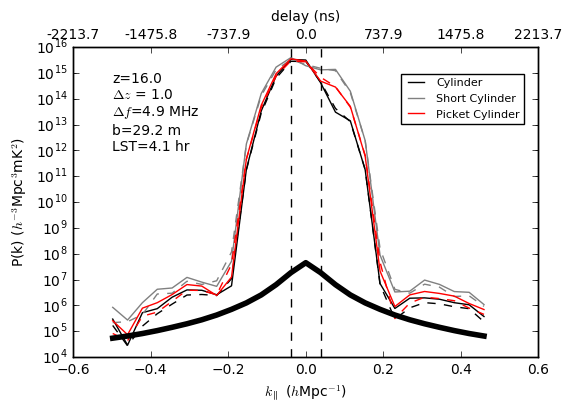

In [16]:
zC=16.
blIndex=2
lstBin=lst60
blLength=dataFiles[0]['bl_length'][blIndex]
delayHorizon=blLength/c
kParaHorizon=cosmology.eta2kpara(delayHorizon,zC)/littleh



fC=cosmology.z2f(zC)
dZ=2.
bandWidth=-cosmology.dz2df(dZ,zC)
fLow=fC-bandWidth/2.
fHigh=fC+bandWidth/2.
print fLow,fC,fHigh
select=n.logical_and(fAxis>fLow,fAxis<=fHigh)

if(n.mod(len(select[select]),2)==1):
    maxInd=n.where(select)[0].max()
    select[maxInd+1]=True
nfs=len(select[select])
fAxisselect=fAxis[select]
tAxisselect=fft.fftshift(fft.fftfreq(nfs,fAxisselect[1]-fAxisselect[0]))
kParAxis=cosmology.eta2kpara(tAxisselect,zC)/littleh

lines=[]


for fileNum,dFile in enumerate(dataFiles):
    antkernel=n.abs(fft.fftshift(fft.fft(fft.fftshift(kernelFiles[fileNum]['bandInterp']))))[select]
    antkernel/=n.sqrt(n.mean(antkernel**2.))
    psSignalModel,psSignalInstances=gen_ps_signal(fAxisselect,dataFiles[0]['bl_length'][blIndex]/3e8*fC,areaSq[fileNum]*df*nfs,ntimes=dataFiles[0]['lst'].shape[0])
    psSignalViss=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances,axes=[0]),axis=0),axes=[0])/(df)
    fgCov,fgCovI=empCov_avgLST(dFile['skyvis_freq'][blIndex,select,:].squeeze()+1e0*psSignalViss,rFactor=0.)
    _,kernelGrid=n.meshgrid(n.ones(len(dFile['lst'])),antkernel)
    fgCovk,fgCovIk=empCov_avgLST(kernelGrid*(dFile['skyvis_freq'][blIndex,select,:].squeeze()+1e0*psSignalViss),rFactor=0.)
    psFFTkernel=powerSpectrum(antkernel*(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+0*psSignalViss[:,lstBin]),zC,bandWidth,areaSq[fileNum],df,mode='FFT',covMatInv=fgCovIk)
    psFFT=powerSpectrum(1*(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+0*psSignalViss[:,lstBin]),zC,bandWidth,areaSq[fileNum],df,mode='FFT',covMatInv=fgCovI)
    p.plot(kParAxis,psFFTkernel,ls='--',color=colors[fileNum])
    lines.append(p.plot(kParAxis,psFFT,ls='-',color=colors[fileNum])[0])

signalPS=gen_ps_signal(fAxisselect,dFile['bl_length'][blIndex]/c*fC,flux=False)
signalPS=signalPS[0]*signalPS[0]*littleh**3.
p.plot(kParAxis,signalPS,color='k',lw=4,ls='-')

p.axvline(-kParaHorizon,color='k',ls='--')
p.axvline(kParaHorizon,color='k',ls='--')
p.yscale('log')
p.ylim(1e3,1e16)
ax1=p.gca()
ax2=p.gca().twiny()
ax2.set_xlim(ax1.get_xlim())
times=cosmology.kpara2eta(ax1.get_xticks(),zC)
ax2labels=[]
for tnum,xtick in enumerate(ax2.get_xticks()):
    ax2labels.append('%.1f'%(times[tnum]*1e9))
ax2.set_xticklabels(ax2labels)
ax1.set_xlabel('$k_\\parallel$ ($h$Mpc$^{-1}$)')
ax1.set_ylabel('P(k) ($h^{-3}$Mpc$^{3}$mK$^2$)')
ax2.set_xlabel('delay (ns)')
p.ylim(1e4,1e16)
p.gcf().legend(lines,
               ('Cylinder','Short Cylinder','Picket Cylinder'),
               loc=[.7,.7],
               ncol=1,
               #bbox_to_anchor=[0.5,-.02],
               fontsize=8)
p.text(-0.5,1e12,'z=%.1f\n$\\Delta z$ = %.1f\n$\\Delta f$=%.1f MHz\nb=%.1f m\nLST=%.1f hr'%(zC,dZ/2,bandWidth/1e6/2,dFile['bl_length'][blIndex],dFile['lst'][lstBin]/15.))
#p.savefig('../analysis/fft_kernel_comparisons_short.pdf',bbox_inches='tight')


78638380.7208 83553279.5159 88468178.3109


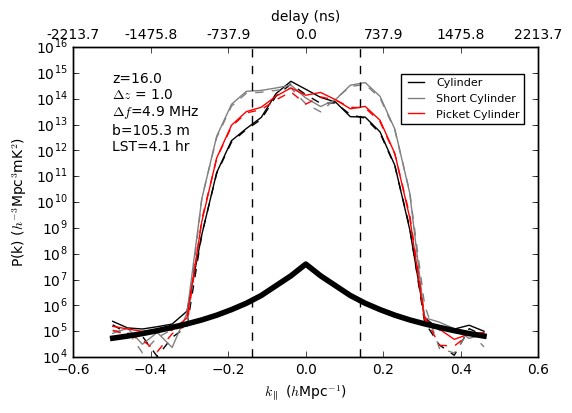

In [15]:
zC=16.
blIndex=24
lstBin=lst60
blLength=dataFiles[0]['bl_length'][blIndex]
delayHorizon=blLength/c
kParaHorizon=cosmology.eta2kpara(delayHorizon,zC)/littleh



fC=cosmology.z2f(zC)
dZ=2.
bandWidth=-cosmology.dz2df(dZ,zC)
fLow=fC-bandWidth/2.
fHigh=fC+bandWidth/2.
print fLow,fC,fHigh
select=n.logical_and(fAxis>fLow,fAxis<=fHigh)

if(n.mod(len(select[select]),2)==1):
    maxInd=n.where(select)[0].max()
    select[maxInd+1]=True
nfs=len(select[select])
fAxisselect=fAxis[select]
tAxisselect=fft.fftshift(fft.fftfreq(nfs,fAxisselect[1]-fAxisselect[0]))
kParAxis=cosmology.eta2kpara(tAxisselect,zC)/littleh

lines=[]


for fileNum,dFile in enumerate(dataFiles):
    antkernel=n.abs(fft.fftshift(fft.fft(fft.fftshift(kernelFiles[fileNum]['bandInterp']))))[select]
    antkernel/=n.sqrt(n.mean(antkernel**2.))
    psSignalModel,psSignalInstances=gen_ps_signal(fAxisselect,dataFiles[0]['bl_length'][blIndex]/3e8*fC,areaSq[fileNum]*df*nfs,ntimes=dataFiles[0]['lst'].shape[0])
    psSignalViss=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances,axes=[0]),axis=0),axes=[0])/(df)
    fgCov,fgCovI=empCov_avgLST(dFile['skyvis_freq'][blIndex,select,:].squeeze()+1e0*psSignalViss,rFactor=0.)
    _,kernelGrid=n.meshgrid(n.ones(len(dFile['lst'])),antkernel)
    fgCovk,fgCovIk=empCov_avgLST(kernelGrid*(dFile['skyvis_freq'][blIndex,select,:].squeeze()+1e0*psSignalViss),rFactor=0.)
    psFFTkernel=powerSpectrum(antkernel*(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+0*psSignalViss[:,lstBin]),zC,bandWidth,areaSq[fileNum],df,mode='FFT',covMatInv=fgCovIk)
    psFFT=powerSpectrum(1*(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+0*psSignalViss[:,lstBin]),zC,bandWidth,areaSq[fileNum],df,mode='FFT',covMatInv=fgCovI)
    p.plot(kParAxis,psFFTkernel,ls='--',color=colors[fileNum])
    lines.append(p.plot(kParAxis,psFFT,ls='-',color=colors[fileNum])[0])

signalPS=gen_ps_signal(fAxisselect,dFile['bl_length'][blIndex]/c*fC,flux=False)
signalPS=signalPS[0]*signalPS[0]*littleh**3.
p.plot(kParAxis,signalPS,color='k',lw=4,ls='-')

p.axvline(-kParaHorizon,color='k',ls='--')
p.axvline(kParaHorizon,color='k',ls='--')
p.yscale('log')
p.ylim(1e3,1e16)
ax1=p.gca()
ax2=p.gca().twiny()
ax2.set_xlim(ax1.get_xlim())
times=cosmology.kpara2eta(ax1.get_xticks(),zC)
ax2labels=[]
for tnum,xtick in enumerate(ax2.get_xticks()):
    ax2labels.append('%.1f'%(times[tnum]*1e9))
ax2.set_xticklabels(ax2labels)
ax1.set_xlabel('$k_\\parallel$ ($h$Mpc$^{-1}$)')
ax1.set_ylabel('P(k) ($h^{-3}$Mpc$^{3}$mK$^2$)')
ax2.set_xlabel('delay (ns)')
p.ylim(1e4,1e16)
p.gcf().legend(lines,
               ('Cylinder','Short Cylinder','Picket Cylinder'),
               loc=[.7,.7],
               ncol=1,
               #bbox_to_anchor=[0.5,-.02],
               fontsize=8)
p.text(-0.5,1e12,'z=%.1f\n$\\Delta z$ = %.1f\n$\\Delta f$=%.1f MHz\nb=%.1f m\nLST=%.1f hr'%(zC,dZ/2,bandWidth/1e6/2,dFile['bl_length'][blIndex],dFile['lst'][lstBin]/15.))
#p.savefig('../analysis/fft_kernel_comparisons_long.pdf',bbox_inches='tight')


81095830.1184 83553279.5159 86010728.9134


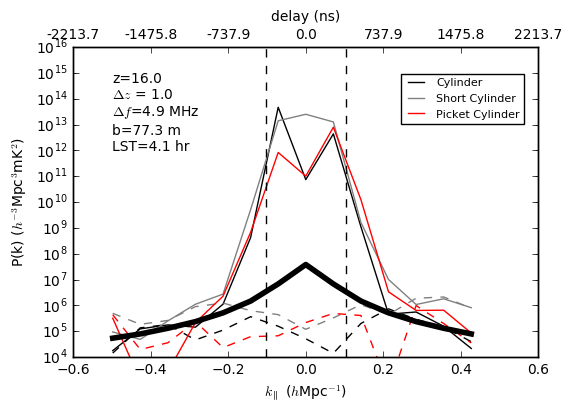

In [22]:
zC=16.
blIndex=12
lstBin=lst60
blLength=dataFiles[0]['bl_length'][blIndex]
delayHorizon=blLength/c
kParaHorizon=cosmology.eta2kpara(delayHorizon,zC)/littleh



fC=cosmology.z2f(zC)
dZ=1.
bandWidth=-cosmology.dz2df(dZ,zC)
fLow=fC-bandWidth/2.
fHigh=fC+bandWidth/2.
print fLow,fC,fHigh
select=n.logical_and(fAxis>fLow,fAxis<=fHigh)

if(n.mod(len(select[select]),2)==1):
    maxInd=n.where(select)[0].max()
    select[maxInd+1]=True
nfs=len(select[select])
fAxisselect=fAxis[select]
tAxisselect=fft.fftshift(fft.fftfreq(nfs,fAxisselect[1]-fAxisselect[0]))
kParAxis=cosmology.eta2kpara(tAxisselect,zC)/littleh

lines=[]


for fileNum,dFile in enumerate(dataFiles):
    antkernel=n.abs(fft.fftshift(fft.fft(fft.fftshift(kernelFiles[fileNum]['bandInterp']))))[select]
    antkernel/=n.sqrt(n.mean(antkernel**2.))
    psSignalModel,psSignalInstances=gen_ps_signal(fAxisselect,dataFiles[0]['bl_length'][blIndex]/3e8*fC,areaSq[fileNum]*df*nfs,ntimes=dataFiles[0]['lst'].shape[0])
    psSignalViss=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances,axes=[0]),axis=0),axes=[0])/(df)
    fgCov,fgCovI=empCov_avgLST(dFile['skyvis_freq'][blIndex,select,:].squeeze()+1e0*psSignalViss,rFactor=0.)
    _,kernelGrid=n.meshgrid(n.ones(len(dFile['lst'])),antkernel)
    fgCovk,fgCovIk=empCov_avgLST(kernelGrid*(dFile['skyvis_freq'][blIndex,select,:].squeeze()+1e0*psSignalViss),rFactor=0.)
    psOQEkernel1=powerSpectrum(antkernel*(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+psSignalViss[:,lstBin]),zC,bandWidth,areaSq[fileNum],df,mode='L^-1',covMatInv=fgCovIk)
    psOQEkernel2=powerSpectrum(antkernel*(dFile['skyvis_freq'][blIndex,select,lstBin]*1e0+psSignalViss[:,lstBin]),zC,bandWidth,areaSq[fileNum],df,mode='F^-1/2',covMatInv=fgCovIk)
    p.plot(kParAxis,psOQEkernel1,ls='--',color=colors[fileNum])
    lines.append(p.plot(kParAxis,psOQEkernel2,ls='-',color=colors[fileNum])[0])

signalPS=gen_ps_signal(fAxisselect,dFile['bl_length'][blIndex]/c*fC,flux=False)
signalPS=signalPS[0]*signalPS[0]*littleh**3.
p.plot(kParAxis,signalPS,color='k',lw=4,ls='-')

p.axvline(-kParaHorizon,color='k',ls='--')
p.axvline(kParaHorizon,color='k',ls='--')
p.yscale('log')
p.ylim(1e3,1e16)
ax1=p.gca()
ax2=p.gca().twiny()
ax2.set_xlim(ax1.get_xlim())
times=cosmology.kpara2eta(ax1.get_xticks(),zC)
ax2labels=[]
for tnum,xtick in enumerate(ax2.get_xticks()):
    ax2labels.append('%.1f'%(times[tnum]*1e9))
ax2.set_xticklabels(ax2labels)
ax1.set_xlabel('$k_\\parallel$ ($h$Mpc$^{-1}$)')
ax1.set_ylabel('P(k) ($h^{-3}$Mpc$^{3}$mK$^2$)')
ax2.set_xlabel('delay (ns)')
p.ylim(1e4,1e16)
p.gcf().legend(lines,
               ('Cylinder','Short Cylinder','Picket Cylinder'),
               loc=[.7,.7],
               ncol=1,
               #bbox_to_anchor=[0.5,-.02],
               fontsize=8)
p.text(-0.5,1e12,'z=%.1f\n$\\Delta z$ = %.1f\n$\\Delta f$=%.1f MHz\nb=%.1f m\nLST=%.1f hr'%(zC,dZ,bandWidth/1e6,dFile['bl_length'][blIndex],dFile['lst'][lstBin]/15.))
p.savefig('../analysis/oqe_kernel_comparisons_longer.pdf',bbox_inches='tight')


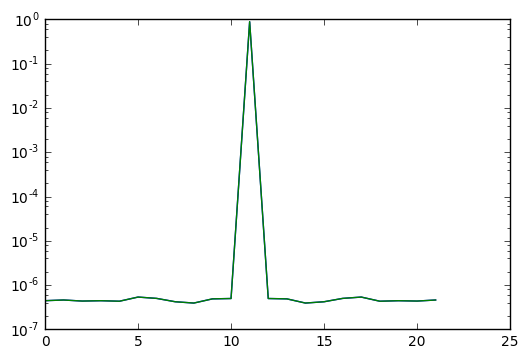

In [22]:
#try experiment with foregrounds and signal toy model
nfsToyMod=22
covToyMod=n.identity(nfsToyMod)*1e-5+n.ones((nfsToyMod,nfsToyMod))
covToyModI=n.linalg.inv(covToyMod)
nSamples=100
pHatAverageL=n.zeros(nfsToyMod,dtype=complex)
pHatAverageF=n.zeros(nfsToyMod,dtype=complex)
for mm in range(nSamples):
    signalToy=n.random.multivariate_normal(n.zeros(nfsToyMod),covToyMod)
    _,pHatToy,_,_,_=oqeFunc(signalToy,wF=n.ones(nfsToyMod),cInv=covToyModI,mode='L^-1')
    pHatAverageL+=pHatToy
    _,pHatToy,_,_,_=oqeFunc(signalToy,wF=n.ones(nfsToyMod),cInv=covToyModI,mode='F^-1/2')
    pHatAverageF+=pHatToy

pHatAverageL/=nSamples
pHatAverageF/=nSamples

p.plot(pHatAverageL)
p.plot(pHatAverageF)

p.yscale('log')

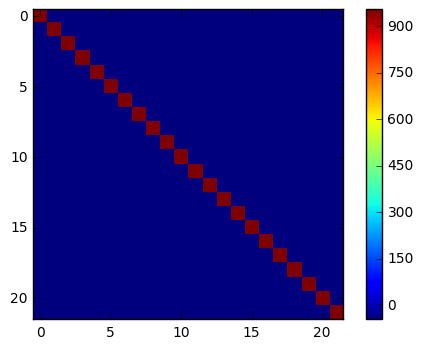

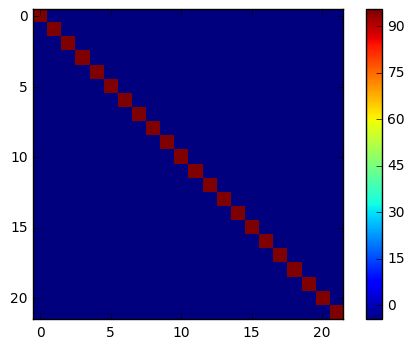

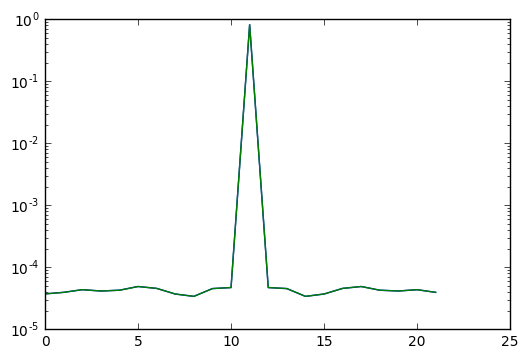

In [30]:
#try experiment with foregrounds and signal toy model
nfsToyMod=22

covToyMod=n.identity(nfsToyMod)*1e-3+n.ones((nfsToyMod,nfsToyMod))
covToyModLarge=n.identity(nfsToyMod)*1e-2+n.ones((nfsToyMod,nfsToyMod))

covToyModI=n.linalg.inv(covToyMod)
covToyModILarge=n.linalg.inv(covToyModLarge)

nSamples=100
pHatAverageL=n.zeros(nfsToyMod,dtype=complex)
pHatAverage=n.zeros(nfsToyMod,dtype=complex)
for mm in range(nSamples):
    signalToy=n.random.multivariate_normal(n.zeros(nfsToyMod),covToyMod)
    _,pHatToy,_,_,_=oqeFunc(signalToy,wF=n.ones(nfsToyMod),cInv=covToyModI,mode='F^-1/2')
    pHatAverage+=pHatToy
    _,pHatToy,_,_,_=oqeFunc(signalToy,wF=n.ones(nfsToyMod),cInv=covToyModILarge,mode='F^-1/2')
    pHatAverageL+=pHatToy

pHatAverageL/=nSamples
pHatAverage/=nSamples

p.imshow(covToyModI,interpolation='nearest')
p.colorbar()
p.show()
p.imshow(covToyModILarge,interpolation='nearest')
p.colorbar()
p.show()

p.plot(pHatAverage)
p.plot(pHatAverageL)

p.yscale('log')